In [1]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [2]:
import io
import os
import re
import shutil
import string
import numpy as np
import pandas as pd
import nltk
import utils

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import TextVectorization, Dense, Embedding, GlobalAveragePooling1D, LSTM, Dropout

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Definition of a Transformer block

Definition of a Transformer block according to [Keras](https://keras.io/examples/nlp/text_classification_with_transformer/).

In [4]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, l2_value=1e-6):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [
                layers.Dense(ff_dim, activation="relu",kernel_regularizer=regularizers.l2(l2_value)),
                layers.Dense(embed_dim, kernel_regularizer=regularizers.l2(l2_value)),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Preprocessing

In [5]:
train = pd.read_csv("subtaskA_train_set.csv")
val = pd.read_csv("subtaskA_val_set.csv")
test = pd.read_csv("subtaskA_test_set.csv")
trainval = pd.read_csv("subtaskA_trainval_set.csv")

## Definition of vocabulary and tokenizer

In [6]:
def create_vocab_data(sentences):
  vocab = []
  for sentence in sentences:
    # lowercase sentence
    sentence = sentence.lower()
    # strip punctuation
    sentence = re.sub('\W+', ' ', sentence)
    # split by whitespace
    tokens = sentence.split(" ")

    for token in tokens:
      if token != "" and token != " ":
        vocab.append(token)

  l = list(set(vocab))
  if "" in l:
    l.remove('')
  return l

In [7]:
vocab_data = create_vocab_data(train["comment_text"].array)
vocab_size = len(vocab_data) + 2
sequence_length = 256 # length of a sequence vector

# Use the text vectorization layer to normalize, split, and map strings to integers.
vectorize_layer = TextVectorization(
  standardize="lower_and_strip_punctuation",
  split="whitespace",
  vocabulary=vocab_data,
  max_tokens=vocab_size,
  output_mode='int',
  output_sequence_length=sequence_length)

# Training of the model

## Model definition

In [8]:
def get_model_with_hp(embedding_dim, num_heads, ff_dim, dense_layer_units, dropout_rate, l2_value, learning_rate, clipnorm):
  # defining inputs
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text_input')

  # Vectorize layer
  net = vectorize_layer(text_input)

  # Embedding layer
  net = Embedding(vocab_size, embedding_dim, name="embedding")(net)

  # Transformer
  net = TransformerBlock(embedding_dim, num_heads, ff_dim, dropout_rate, l2_value)(net)
  net = Dropout(dropout_rate)(net)
  net = GlobalAveragePooling1D()(net)

  # Fully connected layers
  net = Dense(dense_layer_units, name = "fully_connected_layer_1")(net)
  net = Dropout(dropout_rate)(net)

  net = Dense(dense_layer_units, name = "fully_connected_layer_2")(net)
  net = Dropout(dropout_rate)(net)

  net = Dense(dense_layer_units, name = "fully_connected_layer_3")(net)
  net = Dropout(dropout_rate)(net)

  # Output layer
  net = Dense(
      units=1,
      activation="sigmoid",
      name="output_classifier"
  )(net)

  model = tf.keras.Model(text_input, net)

  optimizer = Adam(
    learning_rate = learning_rate,
    clipnorm = clipnorm
  )

  model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics='accuracy'
  )

  return model

def get_model(hp):
  return get_model_with_hp(
    embedding_dim = hp.Choice("Embedding dimension", values=[16, 32, 64]),
    num_heads = hp.Choice("attention heads", values=[2,4,6]),
    ff_dim = hp.Choice("ff dim", values=[16,32]),
    dense_layer_units = hp.Choice("dense layer units", values = [8, 16, 32]),
    dropout_rate = 0.10,
    l2_value = hp.Choice("L2 regularization", values=[1e-6]),
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3]),
    clipnorm = 0.1
  )


## Random search

In [ ]:
tuner = kt.RandomSearch(
    hypermodel=get_model,
    max_trials=8,
    objective='val_accuracy',
    overwrite=True
)

In [9]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=5e-2,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=1e-3,
    min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=20,
    verbose=False,
    restore_best_weights=True
)

In [ ]:
tuner.search(
    x = train["comment_text"],
    y = train["conspiratorial"],
    epochs = 70,
    validation_data = (val["comment_text"], val["conspiratorial"]),
    callbacks = [
        reduce_lr,
        early_stopping
    ]
)

Trial 8 Complete [00h 01m 45s]
val_accuracy: 0.7680723071098328

Best val_accuracy So Far: 0.8132529854774475
Total elapsed time: 00h 18m 03s


In [ ]:
tuner.get_best_hyperparameters(1)[0].values

{'Embedding dimension': 32,
 'attention heads': 2,
 'ff dim': 32,
 'dense layer units': 8,
 'L2 regularization': 1e-06,
 'learning_rate': 0.001}

## Final train of the model

In [10]:
tf.keras.backend.clear_session()

In [58]:
best_model = get_model_with_hp(
    embedding_dim = 32,
    num_heads = 2,
    ff_dim = 32,
    dense_layer_units = 8,
    dropout_rate = 0.1,
    l2_value = 3e-6,
    learning_rate = 8e-3,
    clipnorm = 0.1,
)

history = best_model.fit(
    x = train["comment_text"],
    y = train["conspiratorial"],
    epochs=30,
    validation_data = (val["comment_text"], val["conspiratorial"]),
    batch_size = 256,
    callbacks= [
      tf.keras.callbacks.TensorBoard(log_dir="logs"),
      reduce_lr,
      #early_stopping
    ]
)


Epoch 1/30
6/6 [==============================] - 8s 262ms/step - loss: 1.1695 - accuracy: 0.5072 - val_loss: 0.7161 - val_accuracy: 0.5181 - lr: 0.0080
Epoch 2/30
6/6 [==============================] - 1s 192ms/step - loss: 0.6994 - accuracy: 0.5306 - val_loss: 0.6857 - val_accuracy: 0.5030 - lr: 0.0080
Epoch 3/30
6/6 [==============================] - 1s 191ms/step - loss: 0.6694 - accuracy: 0.5896 - val_loss: 0.6734 - val_accuracy: 0.6145 - lr: 0.0080
Epoch 4/30
6/6 [==============================] - 1s 186ms/step - loss: 0.6460 - accuracy: 0.6689 - val_loss: 0.7771 - val_accuracy: 0.5934 - lr: 0.0080
Epoch 5/30
6/6 [==============================] - 1s 166ms/step - loss: 0.6229 - accuracy: 0.6803 - val_loss: 0.7124 - val_accuracy: 0.5361 - lr: 0.0080
Epoch 6/30
6/6 [==============================] - 1s 196ms/step - loss: 0.5507 - accuracy: 0.6946 - val_loss: 0.6814 - val_accuracy: 0.6747 - lr: 0.0080
Epoch 7/30
6/6 [==============================] - 1s 206ms/step - loss: 0.3988 - a

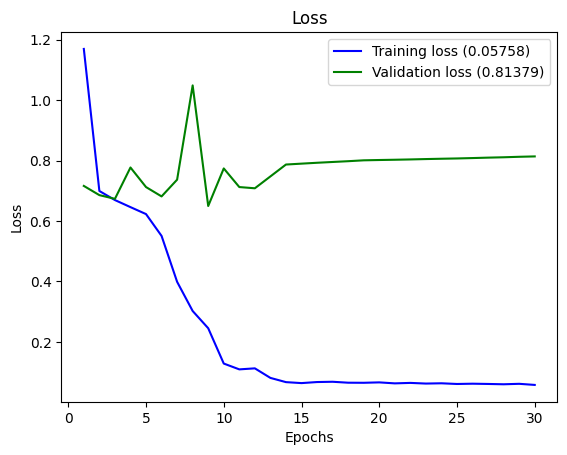

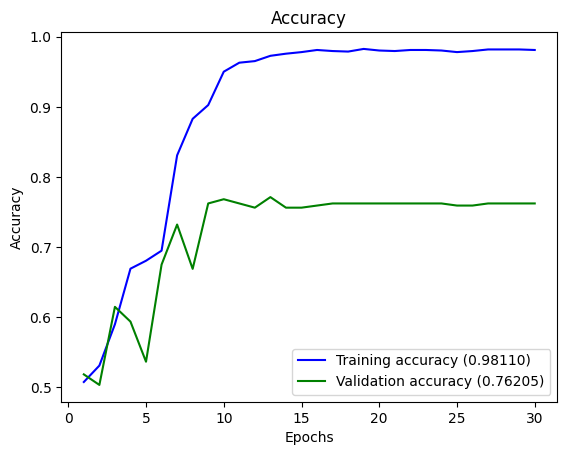

In [60]:
utils.plot_history(history)

In [61]:
best_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 32)           270144    
                                                                 
 transformer_block_22 (Trans  (None, 256, 32)          10656     
 formerBlock)                                                    
                                                                 
 dropout_134 (Dropout)       (None, 256, 32)           0         
                                                                 
 global_average_pooling1d_22  (None, 32)               0  

# Test phase

In [62]:
final_model = get_model_with_hp(
    embedding_dim = 32,
    num_heads = 2,
    ff_dim = 32,
    dense_layer_units = 8,
    dropout_rate = 0.1,
    l2_value = 3e-6,
    learning_rate = 8e-3,
    clipnorm = 0.1,
)

history = final_model.fit(
    x = trainval["comment_text"],
    y = trainval["conspiratorial"],
    batch_size=256,
    epochs=20
)

Epoch 1/20
7/7 [==============================] - 8s 193ms/step - loss: 1.1351 - accuracy: 0.5245
Epoch 2/20
7/7 [==============================] - 1s 177ms/step - loss: 0.7099 - accuracy: 0.5172
Epoch 3/20
7/7 [==============================] - 1s 181ms/step - loss: 0.6823 - accuracy: 0.5619
Epoch 4/20
7/7 [==============================] - 1s 183ms/step - loss: 0.6631 - accuracy: 0.6042
Epoch 5/20
7/7 [==============================] - 1s 158ms/step - loss: 0.6253 - accuracy: 0.6604
Epoch 6/20
7/7 [==============================] - 1s 167ms/step - loss: 0.5303 - accuracy: 0.7462
Epoch 7/20
7/7 [==============================] - 1s 171ms/step - loss: 0.5279 - accuracy: 0.7692
Epoch 8/20
7/7 [==============================] - 1s 211ms/step - loss: 0.3760 - accuracy: 0.8399
Epoch 9/20
7/7 [==============================] - 2s 274ms/step - loss: 0.1678 - accuracy: 0.9498
Epoch 10/20
7/7 [==============================] - 1s 182ms/step - loss: 0.0958 - accuracy: 0.9734
Epoch 11/20
7/7 [==

In [68]:
_ = final_model.evaluate(
    x = test["comment_text"],
    y = test["conspiratorial"],
    batch_size=256
)

1/1 [==============================] - 0s 52ms/step - loss: 3.3796 - accuracy: 0.7676


6/6 [==============================] - 0s 11ms/step


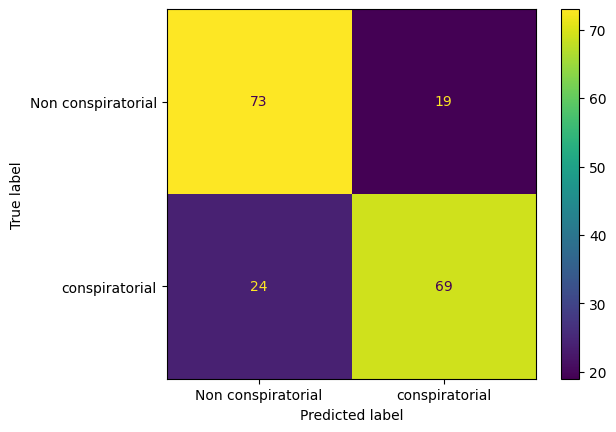

In [66]:
predictions = final_model.predict(x=test["comment_text"])
predictions = list(map(round, [ _[0] for _ in predictions]))

cm = confusion_matrix(test["conspiratorial"], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non conspiratorial", "conspiratorial"])
disp.plot()